In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/web-traffic-time-series-forecasting/sample_submission_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/sample_submission_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip
/kaggle/input/wikipedia-model/best_xgboost_model1.joblib


In [2]:
import joblib

model = joblib.load('/kaggle/input/wikipedia-model/best_xgboost_model1.joblib')

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from tqdm import tnrange
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder,normalize
import re

In [4]:
data = pd.read_csv("/kaggle/input/web-traffic-time-series-forecasting/train_2.csv.zip", compression = "zip")
Page=data['Page']
data=data.drop(columns=['Page']).interpolate(axis=1)
data.fillna(0,inplace=True)
data.insert(loc=0,column='Page',value=Page)

In [5]:
col=data.columns
for i in tnrange(data.shape[0]):
    k=data.iloc[i].values[1:]
    threshold=np.percentile(k,99.9)
    med=np.median(k)
    for j in col[1:]:
        if(data.at[i,j]>threshold):
            data.at[i,j]=med

/tmp/ipykernel_33/3768419286.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(data.shape[0]):


  0%|          | 0/145063 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
import datetime
week_day=[]
temp=[]
l=len(data.columns)

for i in (data.columns[l-20:l]):
    d=i.split('-')
    date=datetime.date(int(d[0]),int(d[1]),int(d[2]))
    temp.append(date.weekday())
    
for j in tqdm(range(data.shape[0])):
    week_day.extend(temp)

    

enc_week_day = OneHotEncoder(sparse=False)
week_day_ohe=enc_week_day.fit_transform(np.array(week_day).reshape(-1,1))

100%|██████████| 145063/145063 [00:00<00:00, 265382.55it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
project_list = ['de', 'en', 'es', 'fr', 'ja', 'nt', 'ru', 'zh']
prj_=[]
for k in tqdm(Page):
    index=k.find('.wikipedia')
    temp = []
    for i in range(20):
        temp.append(project_list.index(k[index-1:index-3:-1][::-1]))
    prj_.extend(temp)

enc_prj = OneHotEncoder(sparse=False)
prj_ohe=enc_prj.fit_transform(np.array(prj_).reshape(-1,1))

prj=[] 
for k in tqdm(Page):
    index=k.find('.wikipedia')
    prj.append(project_list.index(k[index-1:index-3:-1][::-1]))
prj_en=enc_prj.transform(np.array(prj).reshape(-1,1)) 

100%|██████████| 145063/145063 [00:03<00:00, 46910.56it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
100%|██████████| 145063/145063 [00:00<00:00, 512755.57it/s]


In [8]:
spider=[]  # 1 for spider data and 0 for non spider data
for i in tnrange(len(Page)):
    temp = []
    if('spider' in Page[i]):
        for k in range(20):
            temp.append(1)
    else:
        for k in range(20):
            temp.append(0)
    spider.extend(temp)    
          
        
enc_spider = OneHotEncoder(sparse=False)
spider_ohe=enc_spider.fit_transform(np.array(spider).reshape(-1,1))  
spider_=[]  
for i in tnrange(len(Page)):
    if('spider' in Page[i]):
        spider_.append(1)
    else:
        spider_.append(0) 
spider_en=enc_spider.transform(np.array(spider_).reshape(-1,1)) # one hot encoding

/tmp/ipykernel_33/4060093012.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(Page)):


  0%|          | 0/145063 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/tmp/ipykernel_33/4060093012.py:16: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(Page)):


  0%|          | 0/145063 [00:00<?, ?it/s]

In [9]:
access=[] # 0 for all access, 1 for mobile and 2 for desktop
for i in tnrange(len(Page)):
    temp = []
    k=max([i.start() for i in re.finditer('org_',Page[i])])
    if('all-access' in Page[i][k:]):
        for _ in range(20):
            temp.append(0)
    if('mobile' in Page[i][k:]):
        for _ in range(20):
            temp.append(1)
    if('desktop' in Page[i][k:]):
        for _ in range(20):
            temp.append(2)
    access.extend(temp)

    
enc_access = OneHotEncoder(sparse=False)
access_ohe=enc_access.fit_transform(np.array(access).reshape(-1,1))   


access_=[]
for i in tnrange(len(Page)):
    temp_access=[]
    k=max([i.start() for i in re.finditer('org_',Page[i])]) 
    if('all-access' in Page[i][k:]):
        access_.append(0)
    if('mobile' in Page[i][k:]):
        access_.append(1)
    if('desktop' in Page[i][k:]):
        access_.append(2)
access_enc=enc_access.transform(np.array(access_).reshape(-1,1)) 

/tmp/ipykernel_33/2785830256.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(Page)):


  0%|          | 0/145063 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/tmp/ipykernel_33/2785830256.py:22: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(Page)):


  0%|          | 0/145063 [00:00<?, ?it/s]

In [10]:
fourier1_x=[]
fourier2_x=[]
fourier3_x=[]
fourier1_y=[]
fourier2_y=[]
fourier3_y=[]
for t in tnrange(len(Page)):
    fdata = data.iloc[t, 1:].values
    fdata=fdata-np.mean(fdata)
    x=np.fft.fft(fdata) 
    freq=np.linspace(0,803//2,803//2) 
    y=2/803*np.abs(x[0:803//2]) 

    temp=y.copy()
    temp1=temp[20:]
    temp1=np.sort(temp1)
    k=temp1[len(temp1)-3:]
    fourier_temp1_x=[]
    fourier_temp2_x=[]
    fourier_temp3_x=[]
    fourier_temp1_y=[]
    fourier_temp2_y=[]
    fourier_temp3_y=[]
    for i in range(len(k)):
        temp_fourier_x=[]
        temp_fourier_y=[]
        temp_fourier_x.append(freq[list(y).index(k[i])])
        temp_fourier_y.append(list(y).index(k[i]))
        if(i==0):
            fourier1_x.extend(temp_fourier_x)
            fourier1_y.extend(temp_fourier_y)
        if(i==1):
            fourier2_x.extend(temp_fourier_x)
            fourier2_y.extend(temp_fourier_y)
        if(i==2):
            fourier3_x.extend(temp_fourier_x)
            fourier3_y.extend(temp_fourier_y)


/tmp/ipykernel_33/2423179971.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for t in tnrange(len(Page)):


  0%|          | 0/145063 [00:00<?, ?it/s]

In [11]:
date=datetime.date(2017,9,11)
for m in tnrange(64):
    d=date.weekday()
    week_en=enc_week_day.transform(np.array([d]).reshape(-1,1))
    fourdays_1=[]
    fourdays_2=[]
    fourdays_3=[]
    fourierr1_x=[]
    fourierr2_x=[]
    fourierr3_x=[]
    fourierr1_y=[]
    fourierr2_y=[]
    fourierr3_y=[]
    week_trend=[]
    prj=[]
    spider=[]
    access=[]
    week_e=[]
    for i in range(data.shape[0]):
        k=data.iloc[i].values
        fourdays_1.append(k[-1] + k[-2] + k[-3] + k[-4])
        fourdays_2.append(k[-5] + k[-6] + k[-7] + k[-8])
        fourdays_3.append(k[-9] + k[-10] + k[-11] + k[-12])
        fourierr1_x.append(fourier1_x[i])
        fourierr2_x.append(fourier2_x[i])
        fourierr3_x.append(fourier3_x[i])
        fourierr1_y.append(fourier1_y[i])
        fourierr2_y.append(fourier2_y[i])
        fourierr3_y.append(fourier3_y[i])
        week_trend.append(k[-7])
        prj.append(prj_en[i])
        spider.append(spider_en[i])
        access.append(access_enc[i])
        week_e.append(week_en[0])
    fourdays_1=normalize(np.array(fourdays_1).reshape(-1,1),axis=0)
    fourdays_2=normalize(np.array(fourdays_2).reshape(-1,1),axis=0)
    fourdays_3=normalize(np.array(fourdays_3).reshape(-1,1),axis=0)
    fourierr1_x=normalize(np.array(fourierr1_x).reshape(-1,1),axis=0)
    fourierr2_x=normalize(np.array(fourierr2_x).reshape(-1,1),axis=0)
    fourierr3_x=normalize(np.array(fourierr3_x).reshape(-1,1),axis=0)
    fourierr1_y=normalize(np.array(fourierr1_y).reshape(-1,1),axis=0)
    fourierr2_y=normalize(np.array(fourierr2_y).reshape(-1,1),axis=0)
    fourierr3_y=normalize(np.array(fourierr3_y).reshape(-1,1),axis=0)
    week_trend=normalize(np.array(week_trend).reshape(-1,1),axis=0)
    pred_data=np.column_stack((week_e,week_trend,fourdays_1, fourdays_2, fourdays_3,
                               prj,spider,access,fourierr1_x,fourierr2_x,
                           fourierr3_x,fourierr1_y,fourierr2_y,fourierr3_y))  
    pred_value=model.predict(pred_data)
    data[str(date)]=pred_value 
    date += datetime.timedelta(days=1)   

/tmp/ipykernel_33/4101814808.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for m in tnrange(64):


  0%|          | 0/64 [00:00<?, ?it/s]

[20:10:33] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0


In [12]:
key=pd.read_csv('/kaggle/input/web-traffic-time-series-forecasting/key_2.csv.zip')
sub=pd.read_csv('/kaggle/input/web-traffic-time-series-forecasting/sample_submission_2.csv.zip')

In [13]:
ids = key['Page'].values
visits = {} 
for i in tnrange(data.shape[0]):
    date = datetime.date(2017,9,13)
    for j in range(62):
        name = Page[i] + '_' + str(date)
        visits[name] = data.loc[i, str(date)]
        date += datetime.timedelta(days=1)

/tmp/ipykernel_33/1736852275.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(data.shape[0]):


  0%|          | 0/145063 [00:00<?, ?it/s]

In [14]:
for i in tnrange(len(ids)):
    sub.at[i,'Visits']=visits[ids[i]]

/tmp/ipykernel_33/686191674.py:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(ids)):


  0%|          | 0/8993906 [00:00<?, ?it/s]

/tmp/ipykernel_33/686191674.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3696.92138671875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sub.at[i,'Visits']=visits[ids[i]]


In [15]:
sub.head()

,Id,Visits
0,0b293039387a,3696.921387
1,7114389dd824,5846.895996
2,057b02ff1f09,20134.589844
3,bd2aca21caa3,18472.458984
4,c0effb42cdd5,11361.086914


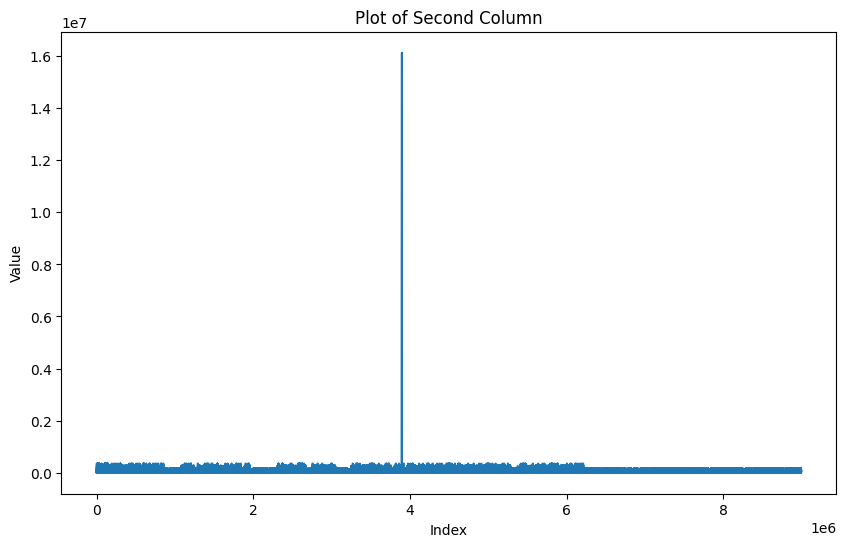

In [16]:
plt.figure(figsize=(10,6))
plt.plot(sub.iloc[:, 1])
plt.title('Plot of Second Column')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

In [17]:
sub.to_csv('/kaggle/working/RF_submit.csv',index=False)

In [18]:
sub.iloc[:, 1].median()

41005.30078125

In [19]:
sub.tail()

,Id,Visits
8993901,f78fbaa305ad,61477.886719
8993902,33aecaf259d1,40969.859375
8993903,a36228b64466,35030.859375
8993904,26887d3e5c99,31435.794922
8993905,06ad06979f80,55220.960938
